In [1]:
import sys
import time

import random
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet_keras import HRNet
from models.u2net import U2NET
from models.erfnet import ERFNet

from data_loader import DataLoader

K.clear_session()
# physical_devices = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    mixed_precision.experimental.set_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
# print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.4.1


In [2]:
# DATA_ROOT ="/home/jupyter/cityscapes_cv/"
# !gsutil cp -r gs://cl_datasets_01/cityscapes/records/trainIds_val.record /cityscapes_cv/gs/
# gsutil cp gs://cl_datasets_01/cityscapes/records/trainIds_train_extra.record /home/ubuntu/cityscapes_cv/gs/

In [3]:
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [6]:
fine = True

if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"

img_height = 128
img_width = 256
n_classes = 20

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catId2label = { label.categoryId : label for label in labels }

In [7]:
if fine:
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
else:
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998

BATCH_SIZE = 4
BUFFER_SIZE = 600

In [8]:
if fine:
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 

In [9]:
pipeline = DataLoader(img_height=img_height, img_width=img_width, n_classes=n_classes)

In [10]:
# Preprocessing: random crop the images and masks, flip them
train = train_ds.map(pipeline.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(pipeline.load_image_test)
eval = test_ds.map(pipeline.load_image_eval)

In [11]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5)) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

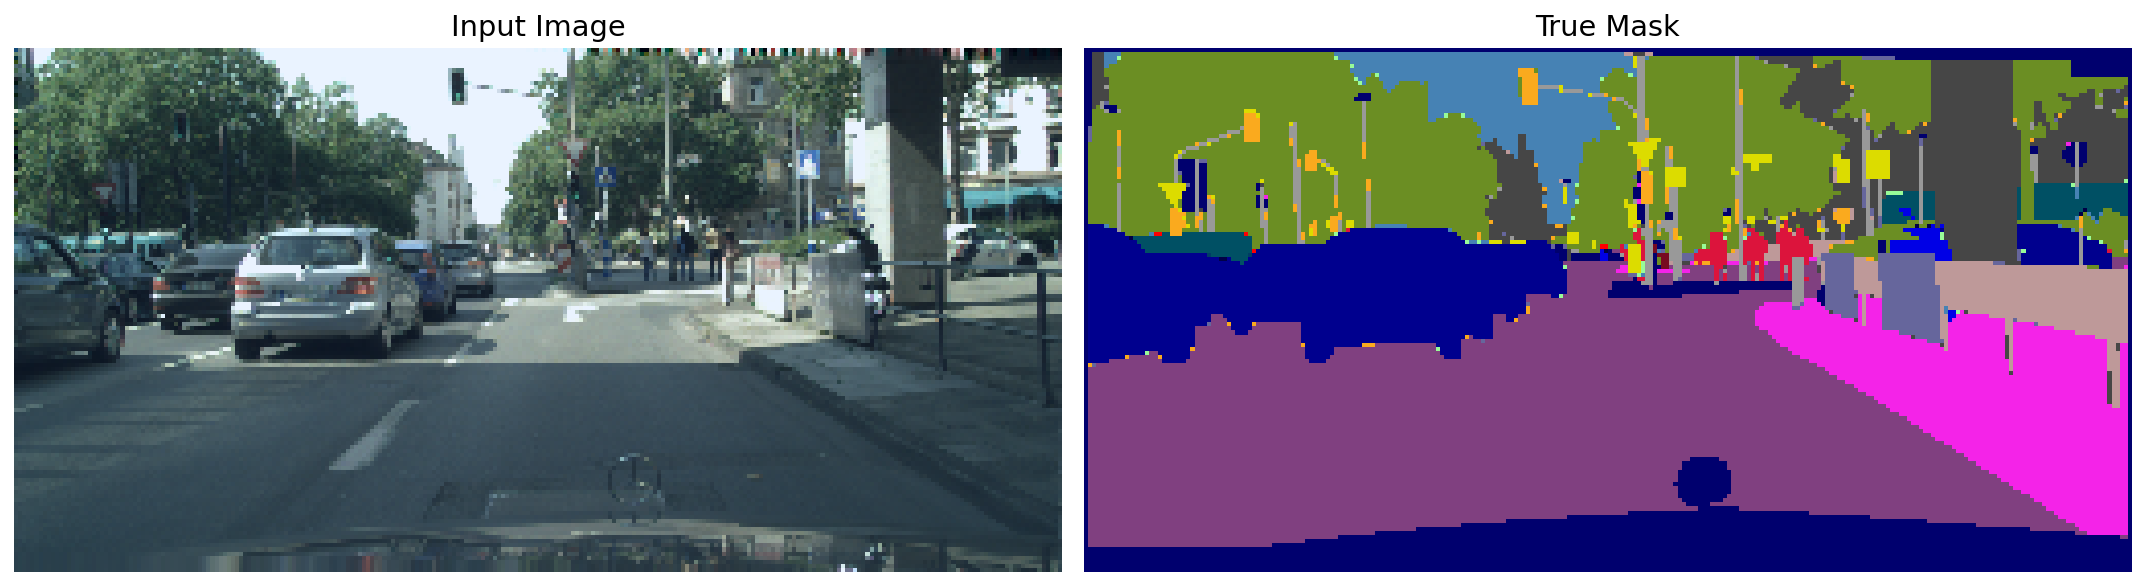

In [13]:
for image, mask in test.take(27): # 16
    sample_image, sample_mask = image, mask

sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "u2net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [15]:
def iou_coef(y_true, y_pred):
    """
    IOU = TP / (TP + FN + FP)
    Gets the IoU score for each class (averaged over the batch), then computes the mean
    When smooth=1, metrics where absent classes contribute to the class mean as 1.0
    """
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        tp = tf.math.reduce_sum(y_pred[:,:,:,i] * y_true[:,:,:,i], axis=(1,2))
        fn = tf.math.reduce_sum(y_true[:,:,:,i] * (1 - y_pred[:,:,:,i]), axis=(1,2)) 
        fp = tf.math.reduce_sum(y_pred[:,:,:,i] * (1 - y_true[:,:,:,i]), axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(tp+smooth, tp+fn+fp+smooth), axis=0)
        iou_total += iou

    iou_macro = iou_total / (n_classes - 1)
    return iou_macro

In [16]:
class DownsamplerBlock(tf.keras.layers.Layer):
    def __init__(self, ch_in, ch_out):
        super(DownsamplerBlock, self).__init__()
        self.conv = Conv2D(ch_out - ch_in, kernel_size=(3, 3), strides=2, padding='same')
        self.pool = MaxPool2D(pool_size=(2, 2), strides=2)
        self.bn = BatchNormalization()

    def call(self, inp, is_training=True):
        out1 = self.conv(inp)
        out2 = self.pool(inp)
        out = layers.Concatenate(axis=-1)([out1, out2])
        out = self.bn(out, training=is_training)
        return out
        

class NonBottleNeck1D(tf.keras.layers.Layer):
    def __init__(self, ch_out, dropout_rate, dilation_rate):
        super(NonBottleNeck1D, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv1 = Conv2D(ch_out, kernel_size=(3, 1), strides=1, padding='same')
        self.conv2 = Conv2D(ch_out, kernel_size=(1, 3), strides=1, padding='same')
        self.bn1 = BatchNormalization()
        self.conv3 = Conv2D(ch_out, kernel_size=(3, 1), strides=1, padding='same', dilation_rate=(dilation_rate, 1))
        self.conv4 = Conv2D(ch_out, kernel_size=(1, 3), strides=1, padding='same', dilation_rate=(1, dilation_rate))
        self.bn2 = BatchNormalization()
        if self.dropout_rate != 0:
            self.drop = Dropout(dropout_rate)

    def call(self, inp, is_training=True):
        out = self.conv1(inp)
        out = tf.nn.relu(out)
        out = self.conv2(out)
        out = self.bn1(out, training=is_training)
        out = tf.nn.relu(out)
        
        out = self.conv3(out)
        out = tf.nn.relu(out)
        out = self.conv4(out)
        out = self.bn2(out, training=is_training)

        if self.dropout_rate != 0:
            out = self.drop(out, training=is_training)
        
        out = layers.Add()([out, inp])
        out = tf.nn.relu(out)

        return out


class UpsamplerBlock(tf.keras.layers.Layer):
    def __init__(self, ch_out):
        super(UpsamplerBlock, self).__init__()
        self.conv = Conv2DTranspose(ch_out, kernel_size=(3, 3), strides=2, padding='same')
        self.bn = BatchNormalization()

    def call(self, inp, is_training=True):
        out = self.conv(inp)
        out = self.bn(out, training=is_training)
        out = tf.nn.relu(out)
        return out


class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.initial_block = DownsamplerBlock(ch_in=3, ch_out=16)

        self.blocks = []
        self.blocks.append(DownsamplerBlock(ch_in=16, ch_out=64))

        for _ in range(5):
            self.blocks.append(NonBottleNeck1D(ch_out=64, dropout_rate=0.03, dilation_rate=1)) 

        self.blocks.append(DownsamplerBlock(ch_in=64, ch_out=128))

        for _ in range(2):
            self.blocks.append(NonBottleNeck1D(ch_out=128, dropout_rate=0.3, dilation_rate=2))
            self.blocks.append(NonBottleNeck1D(ch_out=128, dropout_rate=0.3, dilation_rate=4))
            self.blocks.append(NonBottleNeck1D(ch_out=128, dropout_rate=0.3, dilation_rate=8))
            self.blocks.append(NonBottleNeck1D(ch_out=128, dropout_rate=0.3, dilation_rate=16))
    
    def call(self, inp, is_training=True):
        out = self.initial_block(inp, training=is_training)
        for block in self.blocks:
            out = block(out, training=is_training)
        return out


class Decoder(tf.keras.Model):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.blocks = []
        self.blocks.append(UpsamplerBlock(ch_out=64))
        self.blocks.append(NonBottleNeck1D(ch_out=64, dropout_rate=0, dilation_rate=1))
        self.blocks.append(NonBottleNeck1D(ch_out=64, dropout_rate=0, dilation_rate=1))
        self.blocks.append(UpsamplerBlock(ch_out=16))
        self.blocks.append(NonBottleNeck1D(ch_out=16, dropout_rate=0, dilation_rate=1))
        self.blocks.append(NonBottleNeck1D(ch_out=16, dropout_rate=0, dilation_rate=1))
        self.output_conv = Conv2DTranspose(num_classes, kernel_size=(2, 2), strides=2, padding='same')

    def call(self, inp, is_training=True):
        out = inp
        for block in self.blocks:
            out = block(out, training=is_training)
        out = self.output_conv(out)
        return out


class ERFNet_model(tf.keras.Model):
    def __init__(self, num_classes):
        super(ERFNet_model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(num_classes)

    def call(self, inp, is_training=True):
        out = self.encoder(inp, training=is_training)
        out = self.decoder(out, training=is_training)
        return out
    
    
def ERFNet(input_height, input_width, n_classes):
    
    model = ERFNet_model(num_classes=n_classes)
    
    # Initialize weights of the network
    inp_test = tf.random.normal(shape=(1, input_height, input_width, 3))
    out_test = model(inp_test, is_training=False)

    return model

In [17]:
K.clear_session()
model = ERFNet(input_height=img_height, input_width=img_width, n_classes=n_classes)

In [18]:
# K.clear_session()
# # model = U2NET(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = HRNet(input_height=img_height, input_width=img_width, n_classes=20, W=40)

In [19]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights("weights/HRNet_W40.h5")

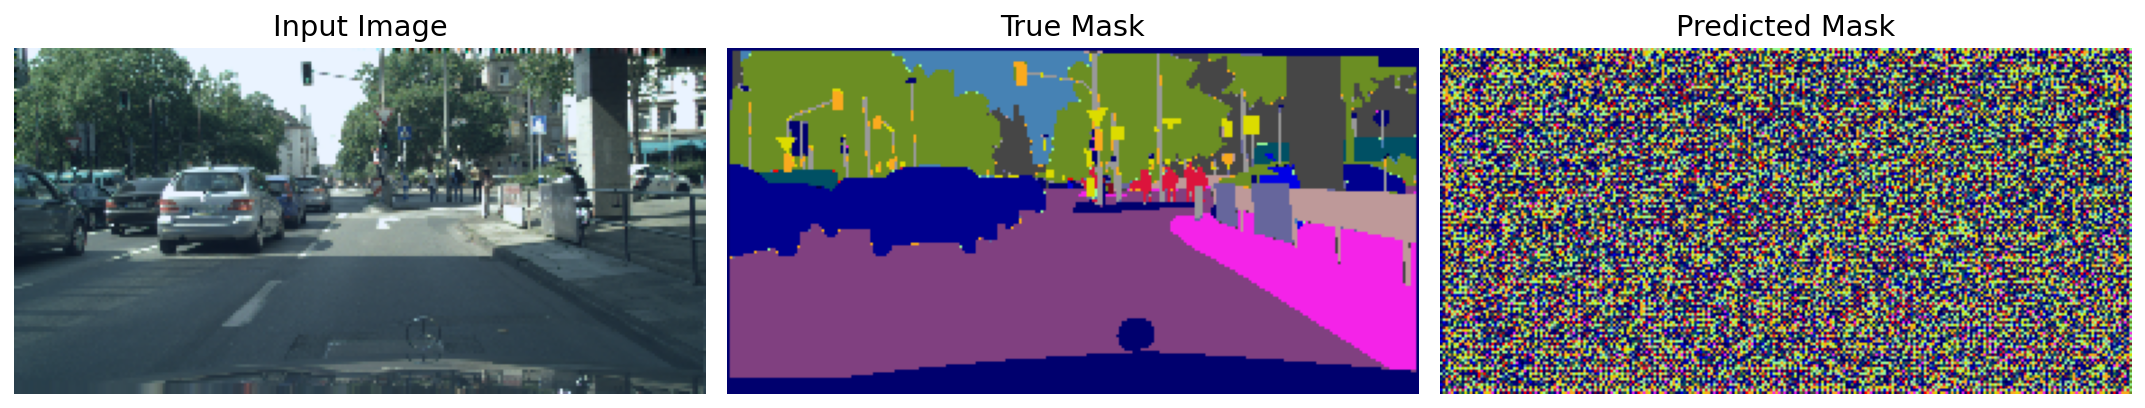

In [20]:
show_predictions()

In [21]:
c_weights = [0,      0.8373, 0.918,  0.866,  1.0345, 
             1.0166, 0.9969, 0.9754, 1.0489, 0.8786,
                1.0023, 0.9539, 0.9843, 1.1116, 0.9037,
                1.0865, 1.0955, 1.0865, 1.1529, 1.0507]


def sce_loss(y_true, y_pred) :
    class_weights = tf.constant([c_weights])
    weights_processed = tf.reduce_sum(class_weights * y_true, axis=-1)
    sce = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred, axis=-1)
    sce = weights_processed * sce
    sce = tf.reduce_mean(sce)
    return sce

In [22]:
cce_loss = tf.keras.losses.CategoricalCrossentropy()


learning_rate_fn = PolynomialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 120000,
    end_learning_rate = 1e-5,
    power=0.9
)


model.compile(
    optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005),
    loss = sce_loss,
    metrics = ['accuracy', iou_coef]
)    

In [23]:
callbacks = [
    DisplayCallback(),
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min'),
]

In [24]:
EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE 

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs = EPOCHS,
    validation_data = test_dataset,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/100
510/743 [===================>..........] - ETA: 1:46 - loss: 1.5121 - accuracy: 0.4140 - iou_coef: 0.0398

In [ ]:
def plot_history(results, model):
        
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  
    if "u2net" in model.name:
        plt.plot(results.history['d0_loss'], 'r', label='Training loss')
        plt.plot(results.history['val_d0_loss'], 'b', label='Validation loss')
    else: 
        plt.plot(results.history['loss'], 'r', label='Training loss')
        plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    if "u2net" in model.name:
        plt.plot(results.history['d0_accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_d0_accuracy'], 'b', label='Validation accuracy')
    else:
        plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    if "u2net" in model.name:
        plt.plot(results.history['d0_iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_d0_iou_coef'], 'b', label='Validation IoU coefficient')
    else:
        plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig(DATA_ROOT+"plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig(DATA_ROOT+"plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

In [ ]:
plot_history(results, model)

### Evaluation

For evaluation IoU scores, we need to calculate the *hard* IoU score as opposed to the *soft* IoU score. We used soft IoU function for training loss. Also, we want to resize everything to the original resolution. 

See this [link](https://www.jeremyjordan.me/semantic-segmentation/)


Variations of mean IoU score
- micro: True positives, false positives, and false negatives are computed globally
- macro: True positives, false positives, and false negatives are computed for each class and their unweighted mean is returned
- weighted: Metrics are computed for each class and returns the mean weighted by the number of true instances in each class 

In [ ]:
def evaluate_iou(model, dataset, n_samples):
    
    iou_macro_scores = np.zeros((n_samples,))
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time.time()
        y_pred = model.predict(X)
        t_end = time.time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "u2net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        # miou_op.reset_states()
        miou_op.update_state(y_true, y_pred)
        iou_macro = miou_op.result().numpy()
        iou_macro_scores[idx] = iou_macro
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return iou_macro_scores, miou_op


def mean_over_valid(x):
    return np.mean(x[x != -1])

To do: Make mean IoU a metric, so you can do

```python
loss, accuracy, miou = model.evaluate(dataset)
```

Might need to write a custom training loop to reset metric states

In [ ]:
# iou_macro_scores, miou_op = evaluate_iou(model=model, dataset=eval, n_samples=25)
iou_macro_scores, miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean_macro = np.mean(iou_macro_scores)

In [ ]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

print("Mean IoU: {:.4f} \n".format(iou_mean_macro))
for i in range(ious.shape[0]) :
    print("IoU for {}: {:.2f}".format(trainid2label[i+1].name, np.round(ious[i], 2)))

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catId2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean_macro,
    current_dir=""
)

In [ ]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean_macro, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)